In [4]:

import spacy

nlp = spacy.load("en_core_web_sm")


# Load Data set

In [5]:
import pandas as pd
import json


In [6]:
df = pd.read_csv("data/yoda_sentences_normalized.csv")

# If the mapping column is stored as a JSON string, convert it to a Python list.
df["mapping"] = df["mapping"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# Word Order

In [7]:

def extract_labels_from_sentence(sentence: str) -> list:
    """
    Parse a canonical English sentence and assign each token a label:
      - 'S' for subject (nsubj or nsubjpass)
      - 'V' for main verb (ROOT)
      - 'O' for object (dobj, attr, or pobj)
      - 'X' for any other token
    Returns:
      A list of labels corresponding to each token in the sentence.
    """
    doc = nlp(sentence)
    labels = []
    for token in doc:
        if token.dep_ in ("nsubj", "nsubjpass"):
            labels.append("S")
        elif token.dep_ == "ROOT":
            labels.append("V")
        elif token.dep_ in ("dobj", "attr", "pobj"):
            labels.append("O")
        else:
            labels.append("X")
    return labels


In [8]:
def map_labels_by_mapping(norm_labels: list, mapping: list[int]) -> list:
    """
    Reorder the list of normalized labels to match the original Yoda sentence using the mapping.
    
    Args:
        norm_labels: List of labels for the normalized sentence.
        mapping: List of integers where mapping[i] is the index of the token in the original Yoda sentence 
                 corresponding to the normalized token at position i.
    
    Returns:
        A list of labels ordered by the original Yoda sentence.
    """
    # Determine length of original sentence (assume max index + 1)
    n = max(mapping) + 1 if mapping else 0
    original_labels = [None] * n
    for norm_idx, orig_idx in enumerate(mapping):
        original_labels[orig_idx] = norm_labels[norm_idx]
    return original_labels

In [9]:
def infer_word_order_from_labels(mapped_labels: list) -> str:
    """
    Given a list of labels (for the original sentence), extract the order of S (subject), V (verb), and O (object)
    by filtering out tokens that are not S, V, or O.
    
    Returns:
        A string representing the word order (e.g. 'OSV'). If one or more roles are missing, appends ' (Incomplete)'.
    """
    order_tokens = [label for label in mapped_labels if label in ("S", "V", "O")]
    incomplete = ""
    if not all(role in order_tokens for role in ("S", "V", "O")):
        incomplete = " (Incomplete)"
    return "".join(order_tokens) + incomplete

In [10]:
normalized_sentence = "He is your father."
example_mapping = [2, 3, 0, 1]  

norm_labels = extract_labels_from_sentence(normalized_sentence)
print("Normalized labels:", norm_labels)
# e.g., output might be: ['S', 'V', 'X', 'O'] 

# 2. Map these labels to the original Yoda sentence order.
mapped_labels = map_labels_by_mapping(norm_labels, example_mapping)
print("Mapped labels:", mapped_labels)
# e.g., the list might become: ['O', 'O', 'S', 'V'] 

# 3. Infer the word order from the mapped labels.
word_order = infer_word_order_from_labels(mapped_labels)
print("Inferred Yoda word order:", word_order)

Normalized labels: ['S', 'V', 'X', 'O', 'X']
Mapped labels: ['X', 'O', 'S', 'V']
Inferred Yoda word order: OSV


In [11]:
def infer_yoda_word_order(row) -> str:
    """
    Given a DataFrame row with columns 'normal_english' and 'mapping',
    computes the Yoda word order using our three-step process.
    """
    normal_text = row["normal_english"]
    mapping = row["mapping"]
    # 1. Extract labels from the normalized sentence
    norm_labels = extract_labels_from_sentence(normal_text)
    # 2. Map these labels to the original Yoda sentence using the provided mapping
    mapped_labels = map_labels_by_mapping(norm_labels, mapping)
    # 3. Infer the word order from the mapped labels
    word_order = infer_word_order_from_labels(mapped_labels)
    return word_order

In [12]:
def infer_normal_word_order(normal_text: str) -> str:
    """
    Computes the word order of a canonical English sentence by:
      1. Extracting token labels from the sentence.
      2. Filtering for S, V, and O tokens in order.
    """
    norm_labels = extract_labels_from_sentence(normal_text)
    return infer_word_order_from_labels(norm_labels)

In [13]:
df_copy = df.copy()

df_copy["normal_word_order"] = df_copy["normal_english"].apply(infer_normal_word_order)
df_copy["yoda_word_order"] = df_copy.apply(infer_yoda_word_order, axis=1)


In [17]:
display(df_copy[["original", "normal_english", "mapping", "yoda_word_order", "normal_word_order"]].head(10))

,original,normal_english,mapping,yoda_word_order,normal_word_order
0,"the very republic is threatened, if involved t...","if the sith are involved, the very republic is...","[5, 7, 8, 9, 6, 0, 1, 2, 3, 4]",SS (Incomplete),SSV (Incomplete)
1,"hard to see, the dark side is.",The dark side is hard to see.,"[3, 4, 5, 6, 0, 1, 2]",SV (Incomplete),SV (Incomplete)
2,"discover who this assassin is, we must.",We must discover who this assassin is.,"[5, 6, 0, 1, 2, 3, 4]",VOSS,SVOS
3,"with this naboo queen you must stay, qui-gon.","Qui-gon, you must stay with this naboo queen.","[7, 4, 5, 6, 0, 1, 2, 3]",SV (Incomplete),SVO
4,protect her.,Protect her.,"[0, 1]",VO (Incomplete),VO (Incomplete)
5,may the force be with you.,May the force be with you.,"[0, 1, 2, 3, 4, 5]",SVO,SVO
6,(cont'd) master qui-gon more to say have you?,"You have more to say, master Qui-Gon (cont'd)?","[7, 6, 3, 4, 5, 1, 2, 0]",OVS,SVOO
7,"a vergence, you say?",You say a vergence?,"[2, 3, 0, 1]",OSV,SVO
8,but you do!,You do but!,"[1, 2, 0]",SV (Incomplete),SV (Incomplete)
9,rrevealed your opinion is.,Your opinion is rrevealed.,"[1, 2, 3, 0]",VS (Incomplete),SV (Incomplete)


In [18]:
import json

In [19]:
df_to_save = df_copy.copy()
df_to_save['mapping'] = df_to_save['mapping'].apply(json.dumps)

df_to_save.to_csv("data/yoda_word_order.csv", index=False)

# Analysis

In [20]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [25]:
word_order_df = pd.read_csv("data/yoda_word_order.csv")

# If the mapping column is stored as a JSON string, convert it to a Python list.
word_order_df["mapping"] = word_order_df["mapping"].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

In [27]:
normal_counts = word_order_df["normal_word_order"].value_counts(normalize=True) * 100
yoda_counts   = word_order_df["yoda_word_order"].value_counts(normalize=True) * 100

In [31]:
print("\nYoda Speech Word Order Distribution:")
for order, pct in yoda_counts.sort_values(ascending=False).items():
    print(f"{order}: {pct:.2f}%")


Yoda Speech Word Order Distribution:
V (Incomplete): 11.80%
SV (Incomplete): 11.80%
OSV: 11.24%
VS (Incomplete): 8.99%
VOS: 8.99%
SVO: 6.74%
VO (Incomplete): 6.18%
OVS: 3.37%
OV (Incomplete): 2.81%
OSVO: 2.25%
VSO: 1.69%
OOSV: 1.69%
SVOO: 1.69%
SVS (Incomplete): 1.69%
OVO (Incomplete): 1.69%
OOOSV: 1.12%
VSOOS: 1.12%
SOS (Incomplete): 1.12%
VOSS: 0.56%
SVOOSV: 0.56%
VSVO: 0.56%
OOVSS: 0.56%
OSVS: 0.56%
VOO (Incomplete): 0.56%
SOSVO: 0.56%
OVOOS: 0.56%
VOOS: 0.56%
SOVO: 0.56%
OSOVO: 0.56%
OOVS: 0.56%
SOOSV: 0.56%
OOVSO: 0.56%
SS (Incomplete): 0.56%
SSV (Incomplete): 0.56%
OOV (Incomplete): 0.56%
VVS (Incomplete): 0.56%
SSO (Incomplete): 0.56%
VSOOO: 0.56%
S (Incomplete): 0.56%
OOOV (Incomplete): 0.56%
SOVSO: 0.56%
VOSOS: 0.56%
OS (Incomplete): 0.56%


In [33]:
print("\nYoda Speech Word Order Distribution:")
for order, pct in yoda_counts.sort_values(ascending=False).items():
    print(f"{order}, ", end="")


Yoda Speech Word Order Distribution:
V (Incomplete), SV (Incomplete), OSV, VS (Incomplete), VOS, SVO, VO (Incomplete), OVS, OV (Incomplete), OSVO, VSO, OOSV, SVOO, SVS (Incomplete), OVO (Incomplete), OOOSV, VSOOS, SOS (Incomplete), VOSS, SVOOSV, VSVO, OOVSS, OSVS, VOO (Incomplete), SOSVO, OVOOS, VOOS, SOVO, OSOVO, OOVS, SOOSV, OOVSO, SS (Incomplete), SSV (Incomplete), OOV (Incomplete), VVS (Incomplete), SSO (Incomplete), VSOOO, S (Incomplete), OOOV (Incomplete), SOVSO, VOSOS, OS (Incomplete), 

                   Normal English  Yoda Speech
OOOSV                    0.000000     1.123596
OOOV (Incomplete)        0.000000     0.561798
OOSV                     0.000000     1.685393
OOSVSO                   0.561798     0.000000
OOV (Incomplete)         0.000000     0.561798
...                           ...          ...
VSOOO                    0.561798     0.561798
VSOOS                    0.000000     1.123596
VSVO                     0.561798     0.561798
VV (Incomplete)          1.123596     0.000000
VVS (Incomplete)         0.000000     0.561798

[64 rows x 2 columns]


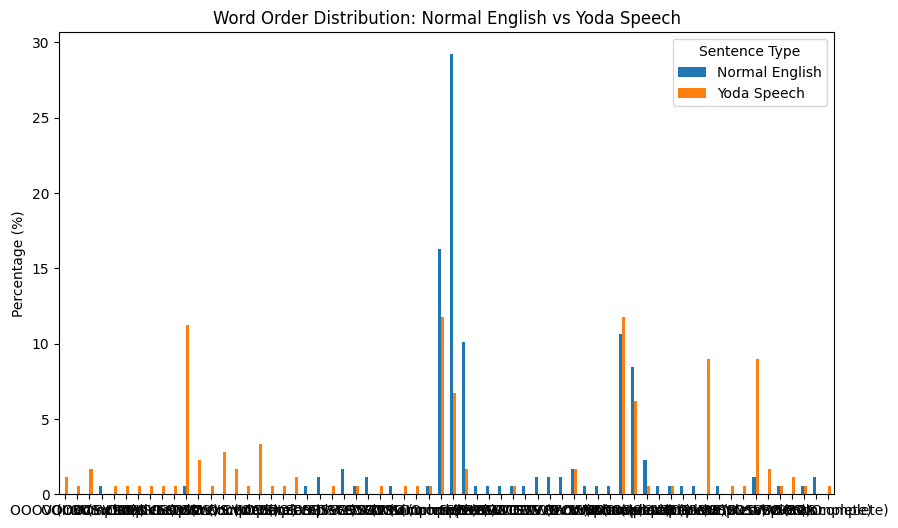

In [23]:
normal_counts = word_order_df["normal_word_order"].value_counts(normalize=True) * 100
yoda_counts   = word_order_df["yoda_word_order"].value_counts(normalize=True) * 100

# Combine the two into a single DataFrame for easier plotting.
combined_df = pd.DataFrame({
    "Normal English": normal_counts,
    "Yoda Speech": yoda_counts
}).fillna(0)  # fill missing categories with 0

print(combined_df)

# Plot the distributions side by side.
ax = combined_df.plot(kind="bar", figsize=(10, 6))
ax.set_ylabel("Percentage (%)")
ax.set_title("Word Order Distribution: Normal English vs Yoda Speech")
plt.xticks(rotation=0)
plt.legend(title="Sentence Type")
plt.show()

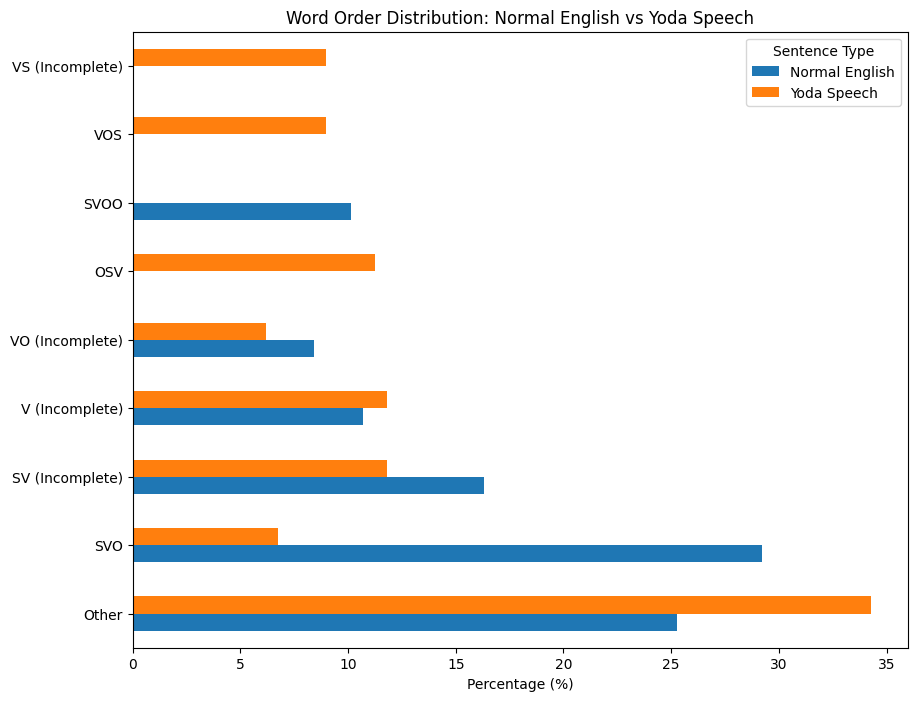

In [26]:
# Compute percentage distributions
normal_counts = word_order_df["normal_word_order"].value_counts(normalize=True) * 100
yoda_counts   = word_order_df["yoda_word_order"].value_counts(normalize=True) * 100

# Combine the distributions
combined_df = pd.DataFrame({
    "Normal English": normal_counts,
    "Yoda Speech": yoda_counts
}).fillna(0)

# Aggregate low-frequency categories: set a threshold (e.g., below 5%)
threshold = 5
def aggregate_low_freq(series, thresh):
    # Separate high frequency and low frequency categories.
    high = series[series >= thresh]
    low = series[series < thresh]
    if not low.empty:
        high["Other"] = low.sum()
    return high

agg_normal = aggregate_low_freq(combined_df["Normal English"], threshold)
agg_yoda   = aggregate_low_freq(combined_df["Yoda Speech"], threshold)

# Align indices of both series for combined plotting
combined_agg = pd.DataFrame({
    "Normal English": agg_normal,
    "Yoda Speech": agg_yoda
}).fillna(0)

# Sort by total frequency
combined_agg["Total"] = combined_agg["Normal English"] + combined_agg["Yoda Speech"]
combined_agg = combined_agg.sort_values("Total", ascending=False)
combined_agg = combined_agg.drop(columns="Total")

# Plot horizontal bar chart
ax = combined_agg.plot(kind="barh", figsize=(10, 8))
ax.set_xlabel("Percentage (%)")
ax.set_title("Word Order Distribution: Normal English vs Yoda Speech")
plt.legend(title="Sentence Type")
plt.show()